# Ordered Logit Regression
using mord module




In [1]:
input_dir = '../input/'
working_dir = '../working/'

In [6]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import mord as md
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
train = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test = pd.read_csv(os.path.join(input_dir, 'test.csv'))

# Set index
train.index = train['Id'].values
test.index = test['Id'].values

# Pick Target
train_target = train['Target']

# Union train and test
all_data = pd.concat([train.drop('Target', axis=1), test], axis=0)

print(train.shape)
print(test.shape)
print(all_data.shape)

(9557, 143)
(23856, 142)
(33413, 142)


In [8]:
# data cleaning
# copy from https://www.kaggle.com/katacs/data-cleaning-and-random-forest
# and make a change it
def data_cleaning(data):
    data['dependency']=np.sqrt(data['SQBdependency'])
#     data['rez_esc']=data['rez_esc'].fillna(0)
    data['v18q1']=data['v18q1'].fillna(0)
    data['v2a1']=data['v2a1'].fillna(0)
    
    data['edjefa'] = data['edjefa'].replace({'no': 0, 'yes': 1})
    data['edjefa'] = data['edjefa'].astype('int')
    data['edjefe'] = data['edjefe'].replace({'no': 0, 'yes': 1})
    data['edjefe'] = data['edjefe'].astype('int')
    meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
    me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
    for row in meaneduc_nan.iterrows():
        idx=row[0]
        idhogar=row[1]['idhogar']
        m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
        data.at[idx, 'meaneduc']=m
        data.at[idx, 'SQBmeaned']=m*m
        
    return data

In [9]:
# train = data_cleaning(train)
# test = data_cleaning(test)
all_data = data_cleaning(all_data)

In [10]:
# Tranform One-hot variables into Categorical variables
def onehot2cat(data, cat_col_new, cat_col_olds):
    cat_col = data[cat_col_olds].idxmax(1)
    cat_col.name = cat_col_new
    cat_col = cat_col.astype('category')
    data = pd.concat([data, cat_col], axis=1)
    data = data.drop(cat_col_olds, axis=1)
    return data

In [11]:
cat_col_new_list = ['pared', 'piso', 'techo', 'abastagua', 'sanitario',
                'energcocinar', 'elimbasu', 'estadocivil',
                'parentesco', 'tipovivi', 'lugar', 'area']
cat_col_dict = {}
for cat_col_new in cat_col_new_list:
    cat_col_olds = [s for s in train.columns.tolist() if s.startswith(cat_col_new)]
    cat_col_dict[cat_col_new] = cat_col_olds
    
cat_col_dict['electricity'] = ['public', 'planpri', 'noelec', 'coopele']
cat_col_dict['sex'] = ['male', 'female']

In [12]:
for cat_col_new, cat_col_olds in cat_col_dict.items():
    print(cat_col_olds)
#     train = onehot2cat(train, cat_col_new, cat_col_olds)
#     test = onehot2cat(test, cat_col_new, cat_col_olds)
    all_data = onehot2cat(all_data, cat_col_new, cat_col_olds)

['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']
['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']
['techozinc', 'techoentrepiso', 'techocane', 'techootro']
['abastaguadentro', 'abastaguafuera', 'abastaguano']
['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']
['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']
['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']
['estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7']
['parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12']
['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']
['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']
['area1', 'area2']
['public', 'planpri', 'noelec', 

In [13]:
# Encode one-hot variables into numeric
# like (bad, regular, good) -> (0 ,1, 2)
def onehot2num(data, status_col_new, status_col_olds):
    status_df = data[status_col_olds]
    status_df.columns = list(range(len(status_col_olds)))
    num_col = status_df.idxmax(1)
    num_col.name = status_col_new
    data = pd.concat([data, num_col], axis=1)
    data = data.drop(status_col_olds, axis=1)
    return data

In [14]:
status_col_new_list = ['epared', 'etecho', 'eviv', 'instlevel']
status_col_dict = {}
for status_col_new in status_col_new_list:
    status_col_olds = [s for s in train.columns.tolist() if s.startswith(status_col_new)]
    status_col_dict[status_col_new] = status_col_olds

In [15]:
for status_col_new, status_col_olds in status_col_dict.items():
    print(status_col_olds)
#     train = onehot2num(train, status_col_new, status_col_olds)
#     test = onehot2num(test, status_col_new, status_col_olds)
    all_data = onehot2num(all_data, status_col_new, status_col_olds)

['epared1', 'epared2', 'epared3']
['etecho1', 'etecho2', 'etecho3']
['eviv1', 'eviv2', 'eviv3']
['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']


In [16]:
# Delete needless columns
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone']
SQB_cols = [s for s in train.columns.tolist() if 'SQB' in s]
needless_cols.extend(SQB_cols)
# train = train.drop(needless_cols, axis=1)
# test = test.drop(needless_cols, axis=1)
all_data = all_data.drop(needless_cols, axis=1)

In [17]:
# Encode overcrowdig variables into crowding rate
all_data['hacdor_rate'] = all_data['hogar_total'] / all_data['bedrooms']
all_data['hacapo_rate'] = all_data['hogar_total'] / all_data['rooms']
all_data = all_data.drop(['hacdor', 'hacapo'], axis=1)

In [18]:
# Encode dummy variables into category type
dummy_col_list = ['cielorazo', 'dis', 'computer', 'television']
for dummy_col in dummy_col_list:
#     train[dummy_col] = train[dummy_col].astype('category')
#     test[dummy_col] = test[dummy_col].astype('category')
    all_data[dummy_col] = all_data[dummy_col].astype('category')

In [19]:
all_data.shape

(33413, 52)

## Aggregate household variables

大人の平均や子供の平均を取るとき、その世帯に大人あるいは子供がいない場合、値はNULLにする。

In [20]:
adult_data = all_data.query('age>18')
child_data = all_data.query('age<=18')

In [21]:
# DataFrameとカラム名が来たら、idhogarでgroupbyして、そのカラムの平均、分散、最小値などを一括で出力する関数

def agg_hogar(df, df_name, col):
    df_g = df.groupby('idhogar')[col]
    
    df_g_mean = df_g.mean()
    df_g_std =  df_g.std()
    df_g_min = df_g.min()
    df_g_median = df_g.median()
    df_g_max = df_g.max()
    df_g_range = df_g_max - df_g_min
    
    df_g_agg = pd.concat([df_g_mean,
                          df_g_std,
                          df_g_min,
                          df_g_median,
                          df_g_max,
                          df_g_range],
                         axis=1)
    
    agg_names = ['mean', 'std', 'min', 'median', 'max', 'range']
    col_names = []
    for agg_name in agg_names:
        col_name = df_name + '_' + col + '_' + agg_name
        col_names.append(col_name)
    df_g_agg.columns = col_names
    
    return df_g_agg

In [22]:
agg_dt_col_dict = {
    'all'  : ['age', 'rez_esc'],
    'adult': ['age', 'escolari', 'instlevel'],
    'child': ['age', 'rez_esc']
}

agg_dt_dict = {
    'all'  : all_data,
    'adult': adult_data,
    'child': child_data
}

In [23]:
hogar_data = all_data.groupby('idhogar')['idhogar'].head(1)
hogar_data.index = hogar_data

for key, cols_list_to_agg in agg_dt_col_dict.items():
    df = agg_dt_dict[key]
    for col in cols_list_to_agg:
        hogar_data = pd.concat([hogar_data, agg_hogar(df, key, col)], axis=1, sort=False)

In [24]:
# add male ratio
all_data_male_ratio = all_data[['Id', 'idhogar', 'sex']].copy()
all_data_male_ratio['is_male'] = all_data_male_ratio['sex']=='male'
is_male_g_mean = all_data_male_ratio.groupby('idhogar')['is_male'].mean()
is_male_g_mean.name = 'male_ratio'
hogar_data = pd.concat([hogar_data, all_data_male_ratio.groupby('idhogar')['is_male'].mean()], axis=1, sort=False)

In [25]:
hogar_data.head()

,idhogar,all_age_mean,all_age_std,all_age_min,all_age_median,all_age_max,all_age_range,all_rez_esc_mean,all_rez_esc_std,all_rez_esc_min,...,child_age_median,child_age_max,child_age_range,child_rez_esc_mean,child_rez_esc_std,child_rez_esc_min,child_rez_esc_median,child_rez_esc_max,child_rez_esc_range,is_male
21eb7fcc1,21eb7fcc1,43.0,NaN,43,43.0,43,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
0e5d7a658,0e5d7a658,67.0,NaN,67,67.0,67,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
2c7317ea8,2c7317ea8,92.0,NaN,92,92.0,92,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2b58d945f,2b58d945f,25.0,14.899664,8,27.0,38,30,0.5,0.707107,0.0,...,12.5,17.0,9.0,0.5,0.707107,0.0,0.5,1.0,1.0,0.50
d6dae86b7,d6dae86b7,19.0,11.690452,7,19.5,30,23,0.5,0.707107,0.0,...,9.0,11.0,4.0,0.5,0.707107,0.0,0.5,1.0,1.0,0.25


## Rent Prediction
### Extract heads of household and tipovivi==3(Room for rent)

In [26]:
hh_data = all_data[all_data['parentesco']=='parentesco1']
rent_data = hh_data[hh_data['tipovivi']=='tipovivi3']
rent_data.shape

(1745, 52)

## Pick up columns related to dwellings

In [27]:
rent_df_col_list = ['v2a1', 'rooms', 'cielorazo', 'idhogar',
                     'bedrooms', 'pared', 'piso', 'techo',
                     'abastagua', 'sanitario', 'energcocinar',
                     'elimbasu', 'lugar', 'area',
                     'electricity', 'epared', 'etecho', 'eviv']

rent_df = rent_data[rent_df_col_list]

rent_idhogar = rent_df['idhogar']
rent_y = rent_df['v2a1']
rent_X = rent_df.drop(['idhogar', 'v2a1'], axis=1)

In [28]:
params = {'num_leaves': 9, 'min_data_in_leaf': 4, 'max_depth': 6}
gbm = lgb.LGBMRegressor(boosting_type='dart', objective='regression', random_state=0)
gbm.set_params(**params)
gbm.fit(rent_X, rent_y)
pred_rent = gbm.predict(all_data[rent_df_col_list].drop(['idhogar', 'v2a1'], axis=1))

## Simple LightGBM

### Merge features

In [29]:
# rent prediction
all_data['pred_rent'] = pred_rent

# aggregated household features
all_data = pd.merge(all_data, hogar_data, on='idhogar', how='left')
all_data.set_index('Id', drop=False, inplace=True)

In [30]:
train = all_data.loc[train.index]
train['Target'] = train_target
train = train[train['parentesco']=='parentesco1']
train = train.drop('parentesco', axis=1)

test = all_data.loc[test.index]
test = test.drop('parentesco', axis=1)

In [40]:
# Split data
train_Id = train['Id'] # individual ID
train_idhogar = train['idhogar'] # household ID
train_y = train['Target'] # Target value
train_X = train.drop(['Id', 'Target', 'idhogar'], axis=1) # features

test_Id = test['Id'] # individual ID
test_idhogar = test['idhogar'] # household ID
test_X = test.drop(['Id', 'idhogar'], axis=1) # features

# Union train and test
# all_Id = pd.concat([train_Id, test_Id], axis=0, sort=False)
# all_idhogar = pd.concat([train_idhogar, test_idhogar], axis=0, sort=False)
# all_X = pd.concat([train_X, test_X], axis=0, sort=False)

# TODO
順序ロジットモデルを適用するためにモジュールmordをインストールした。  
しかし、欠損値をどの数値で埋めるかを決めかねることや、カテゴリ変数が多すぎてダミー化すると次元が多くなりすぎることが障害となり、断念する。

In [39]:
# chage df type as float and fill na by -1
train_X = train_X.astype(float)
train_X = train_X.fillna(-1)
# test_X = test_X.fillna(-1)

ValueError: could not convert string to float: 'paredblolad'

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
import lightgbm as lgb

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.1, random_state=0)

F1_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

# gbm_param = {
#     'leaning_rate':[0.1]
#     ,'n_estimators':[69]
#     ,'num_leaves':[42]
#     ,'min_data_in_leaf':[23]
#     ,'max_depth':[11]
# }
# gbm = GridSearchCV(
#     estimator=lgb.LGBMClassifier(objective='multiclassova', boosting_type='dart', class_weight='balanced', seed=0)
#     , param_grid=gbm_param
#     , scoring=F1_scorer
#     , cv=5
# )


params = {'leaning_rate':0.05, 'n_estimators':69, 'num_leaves': 42, 'min_data_in_leaf': 23, 'max_depth': 11}#, 'feature_fraction': 0.74}
gbm = lgb.LGBMClassifier(objective='multiclassova', boosting_type='dart', class_weight='balanced', random_state=0)
gbm.set_params(**params)

gbm.fit(X_train, y_train)
# gbm.best_params_

LGBMClassifier(boosting_type='dart', class_weight='balanced',
        colsample_bytree=1.0, leaning_rate=0.05, learning_rate=0.1,
        max_depth=11, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=23, min_split_gain=0.0, n_estimators=69,
        n_jobs=-1, num_leaves=42, objective='multiclassova',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [31]:
feature_imp = pd.DataFrame({
    'features'  : X_train.columns,
    'importance': gbm.feature_importances_
    },
    index=X_train.columns)
feature_imp.sort_values('importance', ascending=False, inplace=True)
# feature_imp.sort_values('importance', ascending=False).plot(kind='bar')

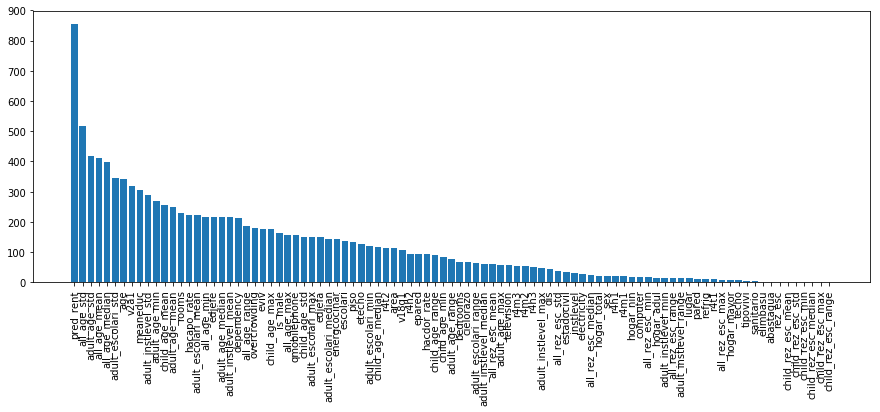

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(feature_imp['features'], feature_imp['importance'])
plt.xticks(rotation=90)
plt.show()

In [33]:
import pickle
with open(os.path.join(working_dir, '20180912_lgbm_rent_agg_hogar.pickle'), mode='wb') as f:
    pickle.dump(gbm, f)

In [34]:
y_test_pred = gbm.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
cm_df_columns = ['pred_'+str(i) for i in range(cm.shape[0])]
cm_df_index = ['true_'+str(i) for i in range(cm.shape[0])]
cm_df = pd.DataFrame(data=cm, columns=cm_df_columns, index=cm_df_index)
f1 = f1_score(y_test, y_test_pred, average='macro')
print("confusion matrix: \n", cm_df)
print("macro F1 score: \n", f1)

confusion matrix: 
         pred_0  pred_1  pred_2  pred_3
true_0      10       5       2       5
true_1       4      20      10      14
true_2       4      14       7      13
true_3       8      15      17     150
macro F1 score: 
 0.45111608287604493


In [35]:
gbm = lgb.LGBMClassifier(objective='multiclassova', class_weight='balanced', random_state=0)
gbm.set_params(**params)
gbm.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, leaning_rate=0.05, learning_rate=0.1,
        max_depth=11, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=23, min_split_gain=0.0, n_estimators=69,
        n_jobs=-1, num_leaves=42, objective='multiclassova',
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
pred = gbm.predict(test_X)
pred = pd.Series(data=pred, index=test_Id.values, name='Target')
pred = pd.concat([test_Id, pred], axis=1, join_axes=[test_Id.index])
pred.to_csv('20180912_lgbm_rent_agg_hogar.csv', index=False)